# 30-Day Hospital Readmission Risk — Clinical Analytics Notebook

**Clinical aim.** Estimate 30-day readmission risk at discharge to prioritize proactive outreach (early clinic visit, medication reconciliation, home health). The model is designed to support value-based care and reduce avoidable readmissions.

**Dataset.** `data/hospital_readmissions_30k.csv`  
**Outcome.** `readmitted_30_days` ∈ {Yes, No} (mapped to 1/0)  
**Repository.** https://github.com/albertokabore/Hospital-Readmission-Prediction

**Decision framing.**  
- Primary: *Recall (Sensitivity)* — identify high-risk patients to avoid missed opportunities.  
- Secondary: *Precision* — efficient use of follow-up resources.  
- Summary: AUROC and AUPRC given class imbalance.

**Method overview.**  
- Robust preprocessing (impute, encode, scale).  
- Baselines + ensembles (DT, RF, GB, AdaBoost, Bagging, XGBoost).  
- Imbalance strategies (SMOTE, undersampling).  
- Hyperparameter tuning with `RandomizedSearchCV`.  
- Interpretability (feature importance / coefficients).


In [153]:
!pip install scikit-learn imbalanced-learn xgboost pandas numpy matplotlib seaborn


In [154]:
!pip install --upgrade -q threadpoolctl


In [155]:
# Import all required libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [156]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
plt.style.use("seaborn-v0_8-whitegrid")

RANDOM_STATE = 42
DATA_PATH = "Dataset_Hospital_readmissions_30k.csv"  # adjust path if needed

print(" HOSPITAL READMISSION ANALYSIS INITIALIZED")

 HOSPITAL READMISSION ANALYSIS INITIALIZED


In [157]:
import os

print("Current working directory:", os.getcwd())
print("Files here:", os.listdir())

Current working directory: c:\Users\alber\Hospital-Readmission-Prediction\notebooks
Files here: ['Readmission_Project.ipynb']


## 0. CONFIGURATION


In [158]:
import os

target_name = "Dataset_Hospital_readmissions_30k.csv"
found_paths = []

for dirpath, dirnames, filenames in os.walk(os.getcwd()):
    if target_name in filenames:
        found_paths.append(os.path.join(dirpath, target_name))

print("Found paths:")
for p in found_paths:
    print(" -", p)


Found paths:


In [159]:
df = pd.read_csv(r"C:\Users\alber\Hospital-Readmission-Prediction\data\Dataset_Hospital_readmissions_30k.csv")


# 1. DATA LOADING AND INITIAL EXPLORATION


### load data

In [167]:
df = pd.read_csv(r"C:\Users\alber\Hospital-Readmission-Prediction\data\Dataset_Hospital_readmissions_30k.csv")


In [174]:
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

print("\nDataset Overview:")
print(f"• Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"• Data types counts: {dict(df.dtypes.value_counts())}")

print("\nFirst 5 rows:")
print(df.head())

Dataset loaded: 30000 rows, 12 columns

Dataset Overview:
• Memory usage: 10.46 MB
• Data types counts: {dtype('O'): np.int64(6), dtype('int64'): np.int64(5), dtype('float64'): np.int64(1)}

First 5 rows:
   patient_id  age  gender blood_pressure  cholesterol    bmi diabetes  \
0           1   74   Other         130/72          240 31.500      Yes   
1           2   46  Female         120/92          292 36.300       No   
2           3   89   Other         135/78          153 30.300       No   
3           4   84  Female         123/80          153 31.500       No   
4           5   32   Other         135/84          205 18.400       No   

  hypertension  medication_count  length_of_stay discharge_destination  \
0           No                 5               1      Nursing_Facility   
1           No                 4               3      Nursing_Facility   
2          Yes                 1               1                  Home   
3          Yes                 3              10      

In [175]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

print("\nMissing Values Analysis:")
if missing_values.sum() == 0:
    print("• No missing values detected")
else:
    for feature, count in missing_values[missing_values > 0].items():
        print(f"• {feature}: {count} missing ({missing_percentage[feature]:.2f}%)")


Missing Values Analysis:
• No missing values detected


In [176]:
print("\n" + "=" * 70)
print("2. TARGET VARIABLE ANALYSIS AND ENCODING")
print("=" * 70)


2. TARGET VARIABLE ANALYSIS AND ENCODING


Target Variable Distribution (readmitted_30_days):
• Not readmitted within 30 days: 26326 patients (87.75%)
• Readmitted within 30 days: 3674 patients (12.25%)


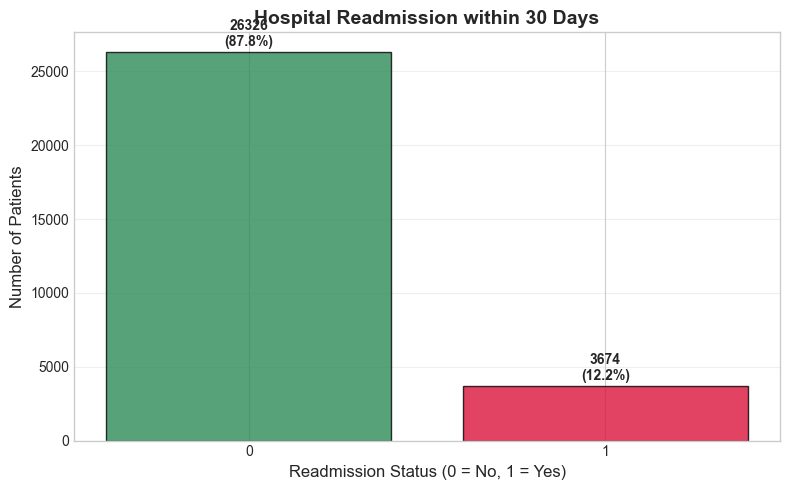

In [177]:

target_col = "readmitted_30_days"

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset.")

df[target_col] = df[target_col].map({"Yes": 1, "No": 0})

target_distribution = df[target_col].value_counts().sort_index()
target_percentage = (target_distribution / len(df)) * 100

print("Target Variable Distribution (readmitted_30_days):")
for value, count in target_distribution.items():
    status = "Not readmitted within 30 days" if value == 0 else "Readmitted within 30 days"
    print(f"• {status}: {count} patients ({target_percentage[value]:.2f}%)")

plt.figure(figsize=(8, 5))
colors = ["#2E8B57", "#DC143C"]
bars = plt.bar(target_distribution.index, target_distribution.values,
               color=colors, alpha=0.8, edgecolor="black")

plt.title("Hospital Readmission within 30 Days", fontsize=14, fontweight="bold")
plt.xlabel("Readmission Status (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Number of Patients", fontsize=12)
plt.xticks([0, 1])
plt.grid(axis="y", alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    cls = target_distribution.index[i]
    pct = target_percentage[cls]
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 200,
             f"{height}\n({pct:.1f}%)",
             ha="center", va="bottom", fontweight="bold")

plt.tight_layout()
plt.show()

In [178]:

positive_rate = target_percentage.get(1, 0.0)
class_ratio = target_distribution[0] / target_distribution[1]
baseline_acc = target_percentage.max()

print("\nClinical Summary:")
print(f"• Readmission rate: {positive_rate:.2f}%")
print(f"• Class imbalance ratio (0:1): {class_ratio:.2f}:1")
print(f"• Baseline accuracy if predicting majority class only: {baseline_acc:.2f}%")



Clinical Summary:
• Readmission rate: 12.25%
• Class imbalance ratio (0:1): 7.17:1
• Baseline accuracy if predicting majority class only: 87.75%


# =============================================================================
# 3. FEATURE PREPROCESSING AND BASIC ANALYSIS
# =============================================================================

In [180]:
print("\n" + "=" * 70)
print("3. FEATURE PREPROCESSING AND BASIC ANALYSIS")
print("=" * 70)

df_engineered = df.copy()

if "blood_pressure" in df_engineered.columns:
    bp_split = df_engineered["blood_pressure"].str.split("/", expand=True)
    df_engineered["systolic_bp"] = pd.to_numeric(bp_split[0], errors="ignore")
    df_engineered["diastolic_bp"] = pd.to_numeric(bp_split[1], errors="ignore")

if "diabetes" in df_engineered.columns:
    df_engineered["diabetes_flag"] = df_engineered["diabetes"].map({"Yes": 1, "No": 0})
if "hypertension" in df_engineered.columns:
    df_engineered["hypertension_flag"] = df_engineered["hypertension"].map({"Yes": 1, "No": 0})

numeric_features = [
    col for col in [
        "age", "cholesterol", "bmi", "medication_count", "length_of_stay",
        "systolic_bp", "diastolic_bp", "diabetes_flag", "hypertension_flag"
    ] if col in df_engineered.columns
]

print(f"Analyzing {len(numeric_features)} numeric features:")
print(numeric_features)



3. FEATURE PREPROCESSING AND BASIC ANALYSIS
Analyzing 9 numeric features:
['age', 'cholesterol', 'bmi', 'medication_count', 'length_of_stay', 'systolic_bp', 'diastolic_bp', 'diabetes_flag', 'hypertension_flag']



Numeric Feature Summary:
             Feature    Mean  Median    Std     Min     Max  Missing
0                age  53.884  54.000 21.056  18.000  90.000        0
1        cholesterol 225.260 225.000 43.586 150.000 300.000        0
2                bmi  28.946  28.900  6.348  18.000  40.000        0
3   medication_count   5.012   5.000  3.166   0.000  10.000        0
4     length_of_stay   5.503   5.000  2.867   1.000  10.000        0
5        systolic_bp 134.968 135.000 14.671 110.000 160.000        0
6       diastolic_bp  85.025  85.000  8.923  70.000 100.000        0
7      diabetes_flag   0.498   0.000  0.500   0.000   1.000        0
8  hypertension_flag   0.499   0.000  0.500   0.000   1.000        0


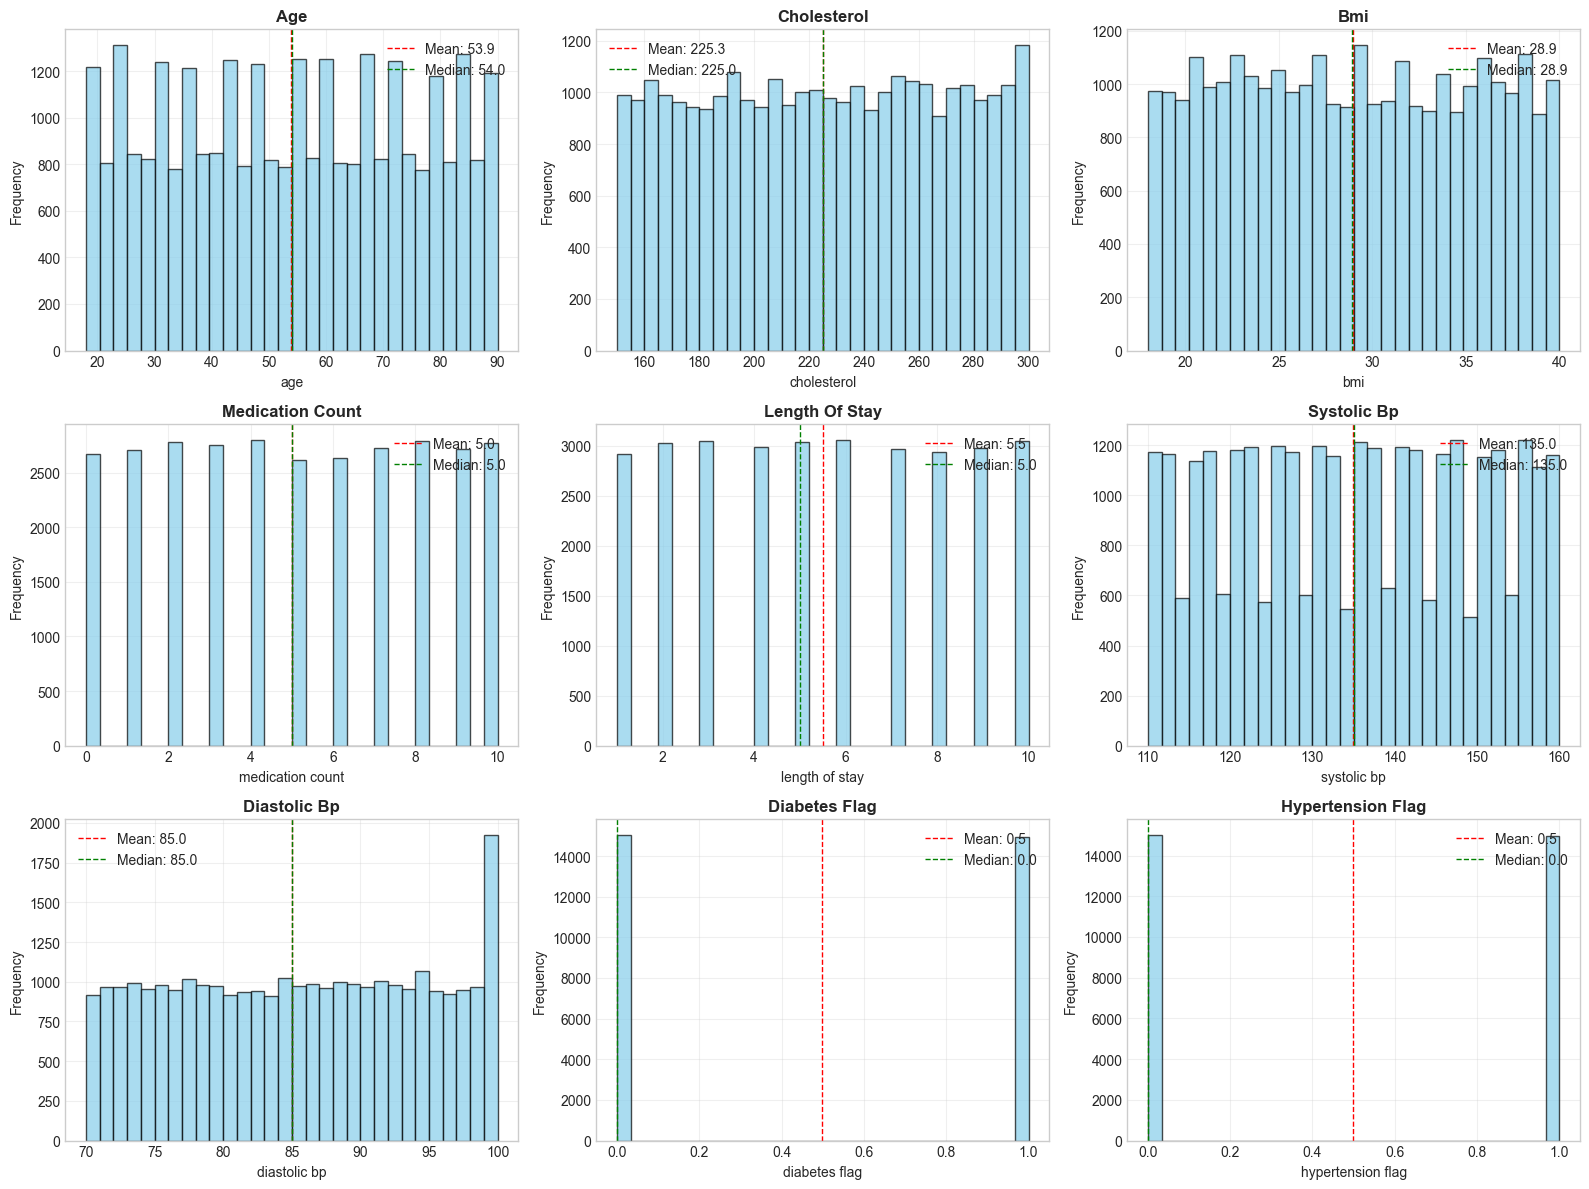

In [181]:
feature_stats = []
for feature in numeric_features:
    feature_stats.append({
        "Feature": feature,
        "Mean": df_engineered[feature].mean(),
        "Median": df_engineered[feature].median(),
        "Std": df_engineered[feature].std(),
        "Min": df_engineered[feature].min(),
        "Max": df_engineered[feature].max(),
        "Missing": df_engineered[feature].isnull().sum()
    })

feature_df = pd.DataFrame(feature_stats)
print("\nNumeric Feature Summary:")
print(feature_df.round(3))

if numeric_features:
    rows = int(np.ceil(len(numeric_features) / 3))
    fig, axes = plt.subplots(rows, 3, figsize=(16, 4 * rows))
    axes = axes.ravel()

    for i, feature in enumerate(numeric_features):
        ax = axes[i]
        ax.hist(df_engineered[feature].dropna(), bins=30,
                alpha=0.7, color="skyblue", edgecolor="black")
        ax.set_title(feature.replace("_", " ").title(), fontweight="bold")
        ax.set_xlabel(feature.replace("_", " "))
        ax.set_ylabel("Frequency")
        ax.grid(alpha=0.3)
        mean_val = df_engineered[feature].mean()
        median_val = df_engineered[feature].median()
        ax.axvline(mean_val, color="red", linestyle="--", linewidth=1, label=f"Mean: {mean_val:.1f}")
        ax.axvline(median_val, color="green", linestyle="--", linewidth=1, label=f"Median: {median_val:.1f}")
        ax.legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

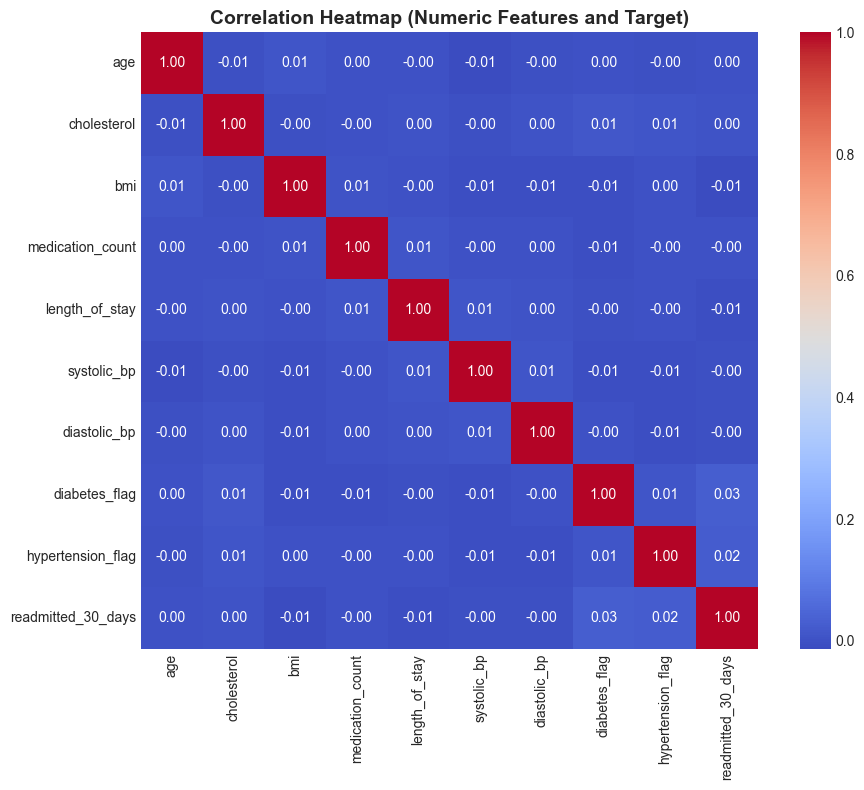

In [182]:
corr_features = numeric_features + [target_col]
corr_matrix = df_engineered[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (Numeric Features and Target)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

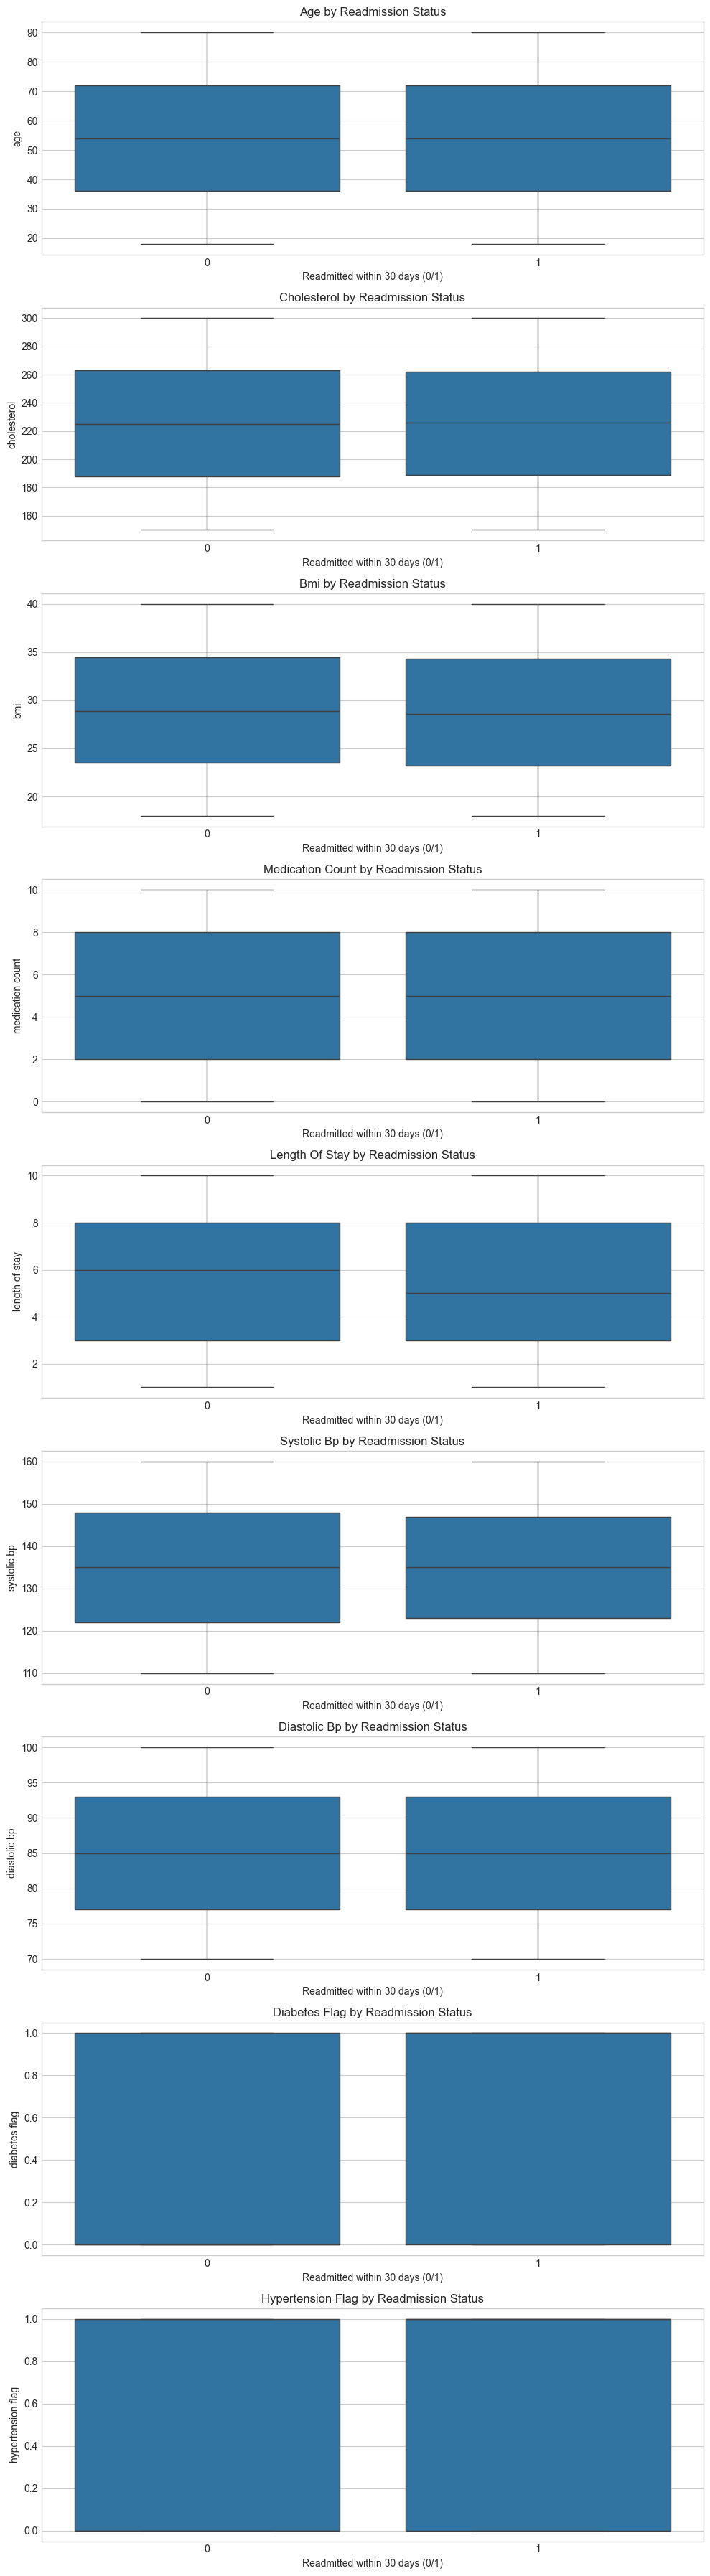

In [184]:

if numeric_features:
    fig, axes = plt.subplots(len(numeric_features), 1, figsize=(10, 4 * len(numeric_features)))
    if len(numeric_features) == 1:
        axes = [axes]

    for i, feature in enumerate(numeric_features):
        sns.boxplot(
            data=df_engineered,
            x=target_col,
            y=feature,
            ax=axes[i]
        )
        axes[i].set_title(f"{feature.replace('_', ' ').title()} by Readmission Status")
        axes[i].set_xlabel("Readmitted within 30 days (0/1)")
        axes[i].set_ylabel(feature.replace("_", " "))

    plt.tight_layout()
    plt.show()



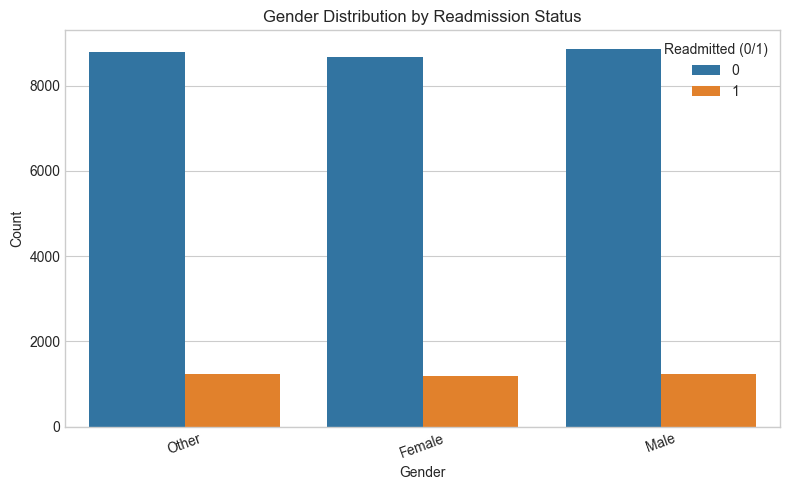

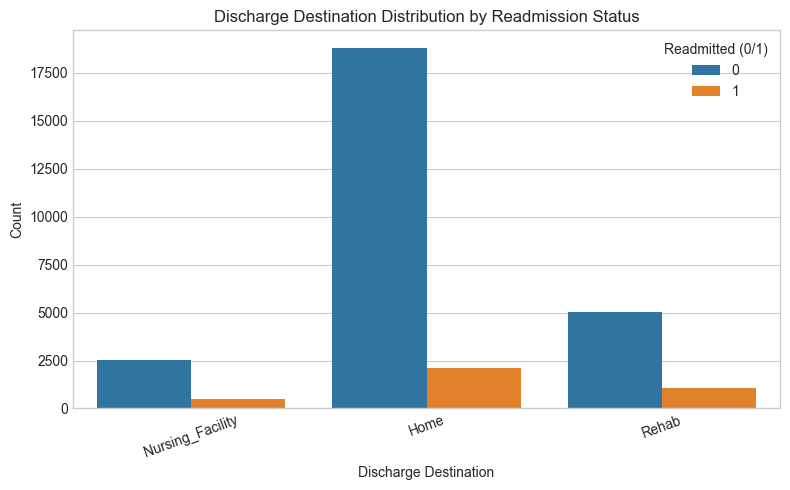

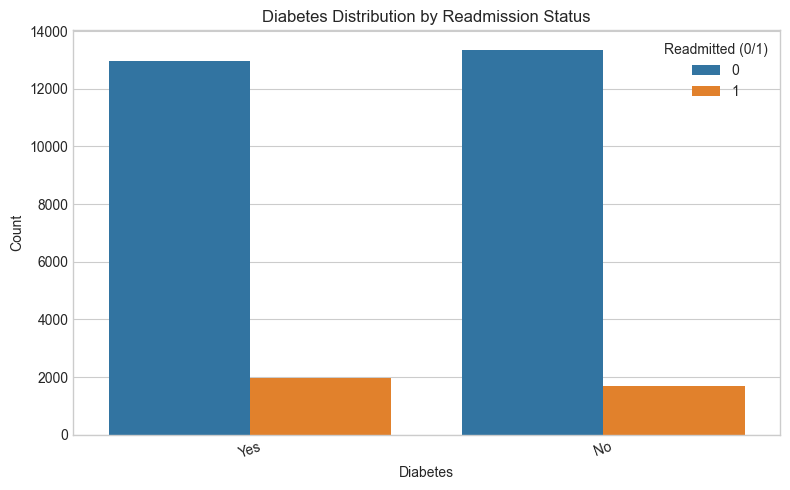

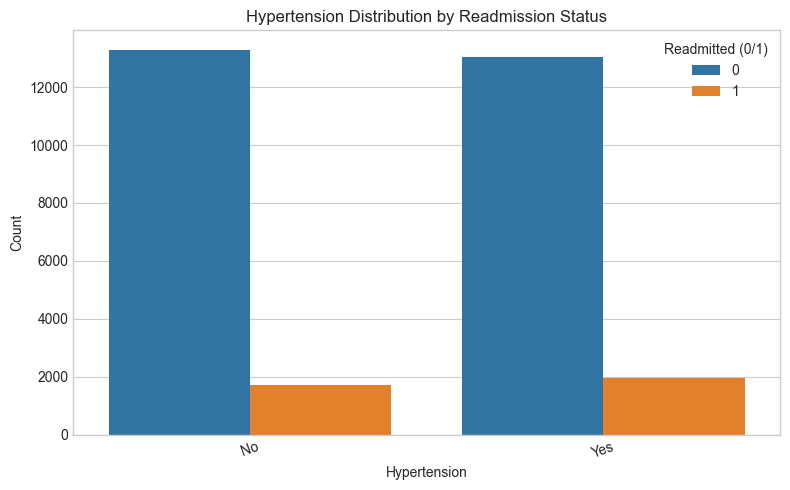

In [185]:
cat_plot_cols = []
for col in ["gender", "discharge_destination", "diabetes", "hypertension"]:
    if col in df_engineered.columns:
        cat_plot_cols.append(col)

for col in cat_plot_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(
        data=df_engineered,
        x=col,
        hue=target_col
    )
    plt.title(f"{col.replace('_', ' ').title()} Distribution by Readmission Status")
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel("Count")
    plt.legend(title="Readmitted (0/1)")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


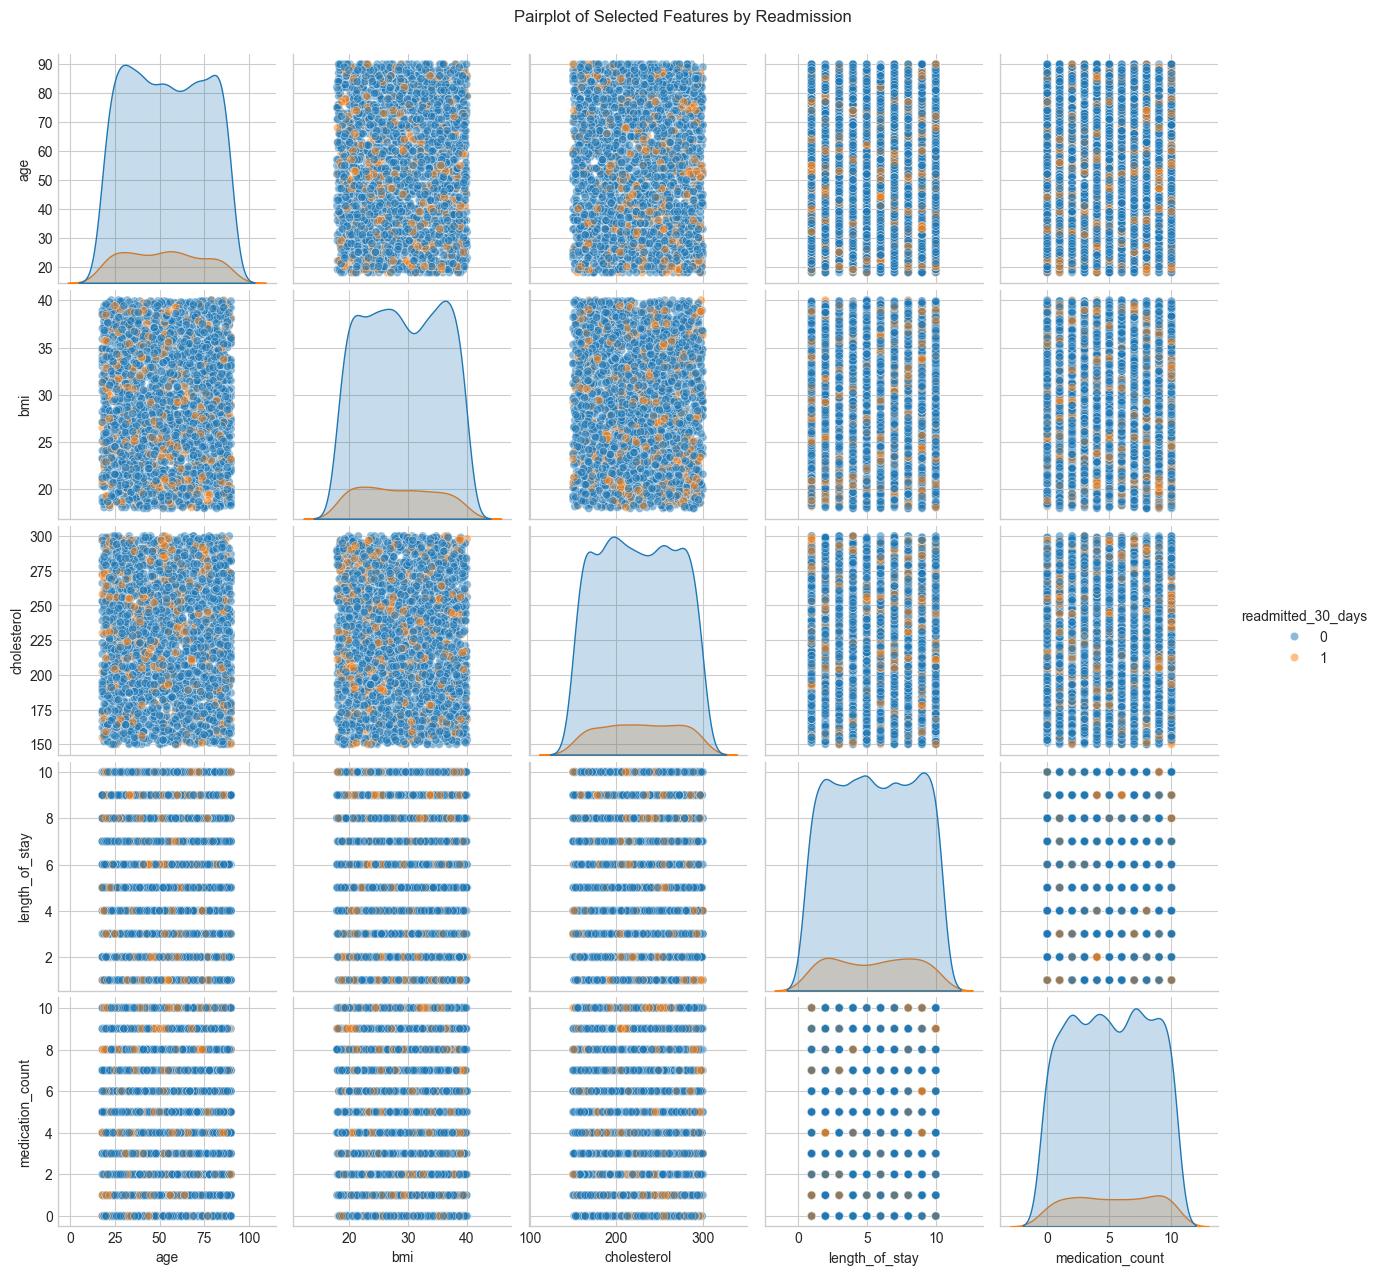

In [ ]:

pairplot_features = [
    f for f in ["age", "bmi", "cholesterol", "length_of_stay", "medication_count"]
    if f in df_engineered.columns
]

if len(pairplot_features) >= 3:
    sample_df = df_engineered[pairplot_features + [target_col]]
    if len(sample_df) > 3000:
        sample_df = sample_df.sample(3000, random_state=RANDOM_STATE)

    sns.pairplot(
        sample_df,
        vars=pairplot_features,
        hue=target_col,
        diag_kind="kde",
        plot_kws={"alpha": 0.5}
    )
    plt.suptitle("Pairplot of Selected Features by Readmission", y=1.02)
    plt.show()


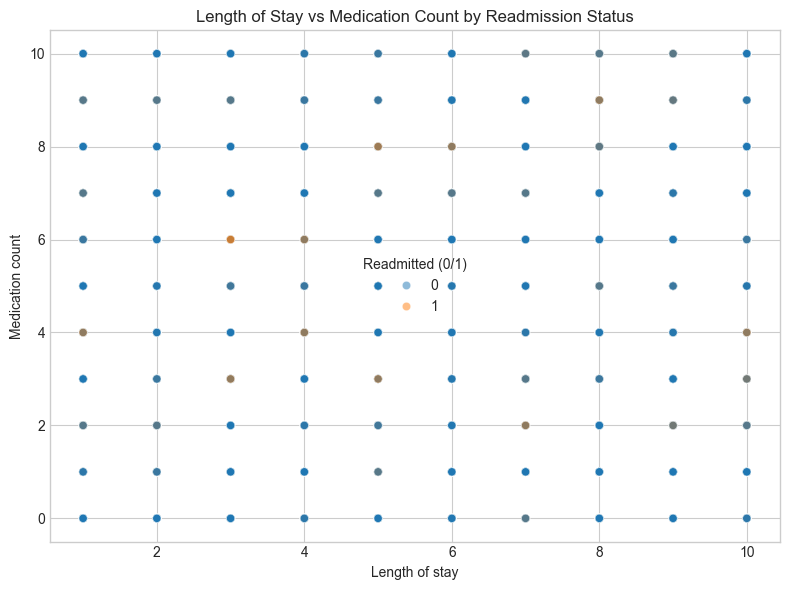

In [187]:
if {"length_of_stay", "medication_count", target_col}.issubset(df_engineered.columns):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_engineered,
        x="length_of_stay",
        y="medication_count",
        hue=target_col,
        alpha=0.5
    )
    plt.title("Length of Stay vs Medication Count by Readmission Status")
    plt.xlabel("Length of stay")
    plt.ylabel("Medication count")
    plt.legend(title="Readmitted (0/1)")
    plt.tight_layout()
    plt.show()

In [188]:

# =============================================================================
# 4. FEATURE ENGINEERING AND TRANSFORMATIONS
# =============================================================================

print("\n" + "=" * 70)
print("4. FEATURE ENGINEERING AND TRANSFORMATIONS")
print("=" * 70)

print("Creating clinical complexity score...")


4. FEATURE ENGINEERING AND TRANSFORMATIONS
Creating clinical complexity score...


In [189]:
complexity_components = []
if "length_of_stay" in df_engineered.columns:
    complexity_components.append("length_of_stay")
if "medication_count" in df_engineered.columns:
    complexity_components.append("medication_count")
if "diabetes_flag" in df_engineered.columns:
    complexity_components.append("diabetes_flag")
if "hypertension_flag" in df_engineered.columns:
    complexity_components.append("hypertension_flag")

scaled_cols = []
for feature in complexity_components:
    std_val = df_engineered[feature].std()
    if std_val == 0 or np.isnan(std_val):
        df_engineered[f"{feature}_scaled"] = 0.0
    else:
        df_engineered[f"{feature}_scaled"] = (
            df_engineered[feature] - df_engineered[feature].mean()
        ) / std_val
    scaled_cols.append(f"{feature}_scaled")

if scaled_cols:
    complexity_score = np.zeros(len(df_engineered))
    weights = np.ones(len(scaled_cols)) / len(scaled_cols)
    for w, col in zip(weights, scaled_cols):
        complexity_score += w * df_engineered[col]

    df_engineered["clinical_complexity_score"] = (
        (complexity_score - complexity_score.min())
        / (complexity_score.max() - complexity_score.min())
        * 100
    )

    conditions = [
        df_engineered["clinical_complexity_score"] < 25,
        df_engineered["clinical_complexity_score"] < 50,
        df_engineered["clinical_complexity_score"] < 75,
        df_engineered["clinical_complexity_score"] >= 75,
    ]
    choices = ["Low", "Medium", "High", "Very High"]
    df_engineered["complexity_category"] = np.select(
        conditions, choices, default="Medium"
    )

    print("• Clinical complexity score and categories created.")
else:
    print("• Not enough components to build a complexity score.")

print("Creating interaction features...")

• Clinical complexity score and categories created.
Creating interaction features...



4. FEATURE ENGINEERING AND TRANSFORMATIONS
Creating clinical complexity score...
• Clinical complexity score and categories created.
Creating interaction features...
• medications_per_day created
• bmi_cholesterol_ratio created
Applying mathematical transformations...
• Log and square root transformations applied to length_of_stay
• Log and square root transformations applied to medication_count
• Log and square root transformations applied to cholesterol

Created 18 new features:
• systolic_bp
• diastolic_bp
• diabetes_flag
• hypertension_flag
• length_of_stay_scaled
• medication_count_scaled
• diabetes_flag_scaled
• hypertension_flag_scaled
• clinical_complexity_score
• complexity_category
• medications_per_day
• bmi_cholesterol_ratio
• length_of_stay_log
• length_of_stay_sqrt
• medication_count_log
• medication_count_sqrt
• cholesterol_log
• cholesterol_sqrt


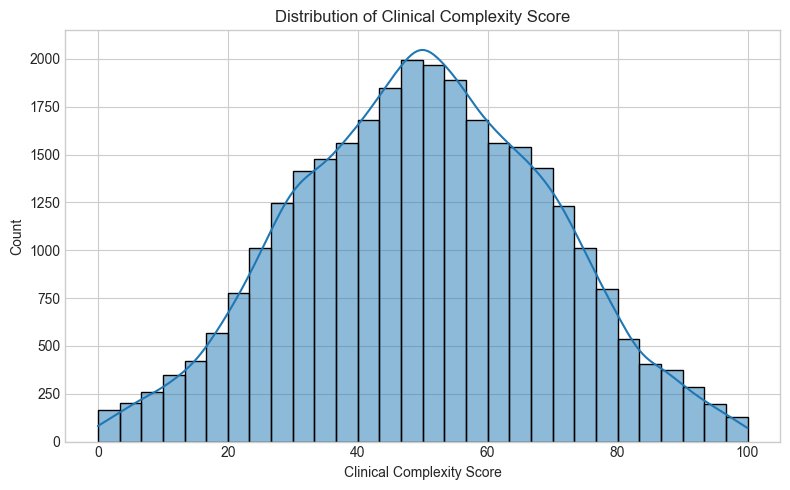

In [191]:

print("\n" + "=" * 70)
print("4. FEATURE ENGINEERING AND TRANSFORMATIONS")
print("=" * 70)

print("Creating clinical complexity score...")

complexity_components = []
if "length_of_stay" in df_engineered.columns:
    complexity_components.append("length_of_stay")
if "medication_count" in df_engineered.columns:
    complexity_components.append("medication_count")
if "diabetes_flag" in df_engineered.columns:
    complexity_components.append("diabetes_flag")
if "hypertension_flag" in df_engineered.columns:
    complexity_components.append("hypertension_flag")

scaled_cols = []
for feature in complexity_components:
    std_val = df_engineered[feature].std()
    if std_val == 0 or np.isnan(std_val):
        df_engineered[f"{feature}_scaled"] = 0.0
    else:
        df_engineered[f"{feature}_scaled"] = (
            df_engineered[feature] - df_engineered[feature].mean()
        ) / std_val
    scaled_cols.append(f"{feature}_scaled")

if scaled_cols:
    complexity_score = np.zeros(len(df_engineered))
    weights = np.ones(len(scaled_cols)) / len(scaled_cols)
    for w, col in zip(weights, scaled_cols):
        complexity_score += w * df_engineered[col]

    df_engineered["clinical_complexity_score"] = (
        (complexity_score - complexity_score.min())
        / (complexity_score.max() - complexity_score.min())
        * 100
    )

    conditions = [
        df_engineered["clinical_complexity_score"] < 25,
        df_engineered["clinical_complexity_score"] < 50,
        df_engineered["clinical_complexity_score"] < 75,
        df_engineered["clinical_complexity_score"] >= 75,
    ]
    choices = ["Low", "Medium", "High", "Very High"]
    df_engineered["complexity_category"] = np.select(
        conditions, choices, default="Medium"
    )

    print("• Clinical complexity score and categories created.")
else:
    print("• Not enough components to build a complexity score.")

print("Creating interaction features...")

if "medication_count" in df_engineered.columns and "length_of_stay" in df_engineered.columns:
    df_engineered["medications_per_day"] = (
        df_engineered["medication_count"] / df_engineered["length_of_stay"]
    )
    df_engineered["medications_per_day"] = df_engineered["medications_per_day"].replace(
        [np.inf, -np.inf], df_engineered["medication_count"].median()
    )
    print("• medications_per_day created")

if "bmi" in df_engineered.columns and "cholesterol" in df_engineered.columns:
    df_engineered["bmi_cholesterol_ratio"] = (
        df_engineered["bmi"] / df_engineered["cholesterol"]
    )
    print("• bmi_cholesterol_ratio created")

print("Applying mathematical transformations...")

features_to_transform = []
for col in ["length_of_stay", "medication_count", "cholesterol"]:
    if col in df_engineered.columns:
        features_to_transform.append(col)

for feature in features_to_transform:
    df_engineered[f"{feature}_log"] = np.log1p(df_engineered[feature])
    df_engineered[f"{feature}_sqrt"] = np.sqrt(df_engineered[feature])
    print(f"• Log and square root transformations applied to {feature}")

engineered_features = [
    col for col in df_engineered.columns if col not in df.columns
]

print(f"\nCreated {len(engineered_features)} new features:")
for feature in engineered_features:
    print(f"• {feature}")

if "clinical_complexity_score" in df_engineered.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(
        df_engineered["clinical_complexity_score"],
        bins=30,
        kde=True
    )
    plt.title("Distribution of Clinical Complexity Score")
    plt.xlabel("Clinical Complexity Score")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# =============================================================================
# 5. VALIDATION OF ENGINEERED FEATURES
# =============================================================================